# Predindo a cotação do Bitcoin usando redes LSTM

### Membros

* Gabriel Pessoa
* Ícaro Guerra
* Lucas Barros
* Matheus Pessoa
* Rafael Mota


In [180]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [181]:
train_ratio = 0.8
max_epochs = 1000
patience = 20
verbose=1
metrics = []

In [182]:
data = pd.read_csv("./btc.csv").sort_index(ascending=False)

data.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [183]:
prices = data["Close"].values

prices

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

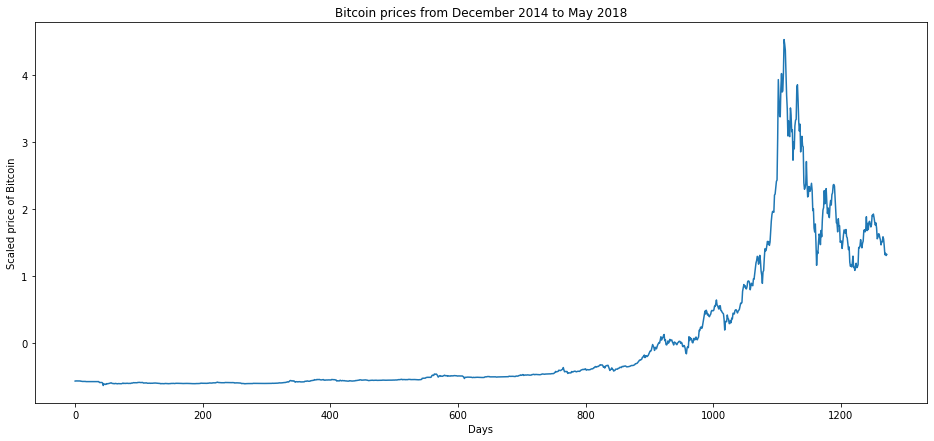

In [184]:
scaler = StandardScaler()

scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_prices, label='Price')
plt.show()


In [194]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return np.array(X), np.array(y)

def split_train_test(x, y):
    train_size = int(len(data) * train_ratio)

    x_train = reshape(x[:train_size])
    y_train = reshape(y[:train_size])

    x_test = reshape(x[train_size:])
    y_test = reshape(y[train_size:])

    return x_train, y_train, x_test, y_test

def reshape(data):
    return np.reshape(data, (data.shape[0], 1, data.shape[1]))

def plot_result(model, x_train, x_test):
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)

    test_results = ([None] * len(y_train_pred)) + list(y_test_pred)

    #we now plot predictions from the network
    plt.figure(figsize=(16, 7))
    plt.title('Bitcoin prices from December 2014 to May 2018')
    plt.xlabel('Days')
    plt.ylabel('Scaled Price of Bitcoin')
    plt.plot(scaled_prices, label='Original data')
    plt.plot(y_train_pred, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

In [186]:
window_size = 3

x, y = window_data(scaled_prices, window_size)
x_train, y_train, x_test, y_test = split_train_test(x, y)

In [187]:
model = keras.Sequential([
    layers.LSTM(100,input_shape=(1, window_size)),
    layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.fit(x_train, y_train, epochs=max_epochs, batch_size=window_size, callbacks=[EarlyStopping(monitor="loss", patience=patience)])

Epoch 1/1000
340/340 [==============================] - 6s 5ms/step - loss: 0.0146
Epoch 2/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.4214e-04
Epoch 3/1000
340/340 [==============================] - 2s 5ms/step - loss: 3.4891e-04
Epoch 4/1000
340/340 [==============================] - 2s 5ms/step - loss: 3.3634e-04
Epoch 5/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.3599e-04
Epoch 6/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.5228e-04
Epoch 7/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.2991e-04
Epoch 8/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.3289e-04
Epoch 9/1000
340/340 [==============================] - 1s 3ms/step - loss: 3.4906e-04
Epoch 10/1000
340/340 [==============================] - 1s 4ms/step - loss: 3.2656e-04
Epoch 11/1000
340/340 [==============================] - 1s 3ms/step - loss: 3.2859e-04
Epoch 12/1000
340/340 [======================

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


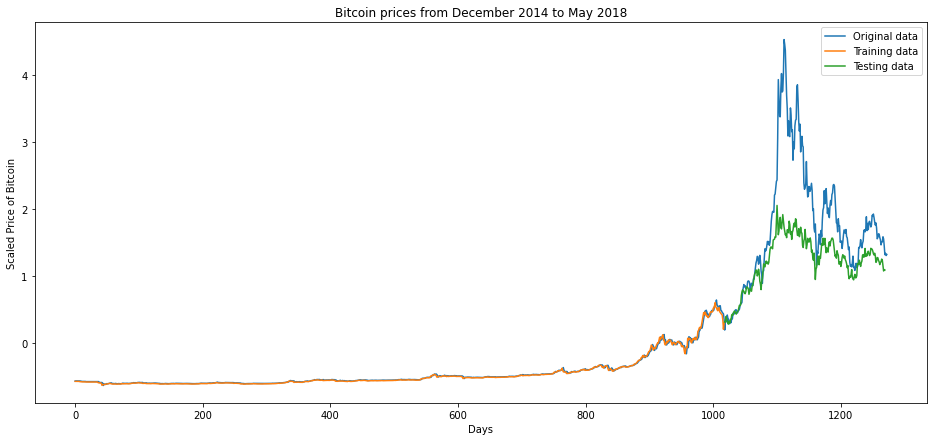

In [195]:
plot_result(model, x_train, x_test)